# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [ ]:
%matplotlib inline
import os
#The OS module in Python provides a way of using operating system dependent functionality. 
#The functions that the OS module provides allows you to interface with the underlying operating system that Python is running on – be that Windows, Mac or Linux.

#PyTorch is an open source 
#machine learning library used for developing and training neural network based deep learning models. It is primarily developed by Facebook's AI research group

#Torchvision library, which is a part of Pytorch, contains all the important datasets as well as models and transformation operations
#generally used in the field of computer vision It allows you to import datasets without any hassle.. 
import torchvision

#All datasets are subclasses of torch.utils.data.Dataset i.e, they have __getitem__ and __len__ methods implemented
import torchvision.datasets as dset  

#Transforms are common image transformations
import torchvision.transforms as transforms  

from torch.utils.data import DataLoader,Dataset 
#At the heart of PyTorch data loading utility is the torch.utils.data.DataLoader class. It represents a Python iterable over a dataset, with support for
#DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,batch_sampler=None, num_workers=0, collate_fn=None,pin_memory=False, drop_last=False, timeout=0,worker_init_fn=None)
#The most important argument of DataLoader constructor is dataset, which indicates a dataset object to load data from. PyTorch supports two different types of datasets: 
#1)map-style datasets, 2)iterable-style datasets.



import matplotlib.pyplot as plt
#matplotlib. pyplot is a collection of command style functions that make matplotlib work like MATLAB.
#Each pyplot function makes some change to a figure:e.g., creates a figure,creates a plotting area in a figure, plots some lines in a plotting area,decorates the plot with labels,etc.


import torchvision.utils
#

import numpy as np
#NumPy is a library for the Python programming language, adding support for large, 
#multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays

import random
#This module implements pseudo-random number generators for various distributions.

from PIL import Image
#Python Imaging Library (abbreviated as PIL) (in newer versions known as Pillow) is a free and open-source additional library for the Python programming language that 
#adds support for opening, manipulating, and saving many different image file formats. It is available for Windows, Mac OS X and Linux.

import torch
#Torch is an open-source machine learning library, a scientific computing framework, and a script language based on the Lua programming language.
# It provides a wide range of algorithms for deep learning, and uses the scripting language LuaJIT, and an underlying C implementation.

from torch.autograd import Variable
#A PyTorch Variable is a wrapper around a PyTorch Tensor, and represents a node in a computational graph.
# If x is a Variable then x.data is a Tensor giving its value, and x.grad is another Variable holding the gradient of x with respect to some scalar value.

#PyTorch Variables have the same API as PyTorch tensors:
#(almost) any operation you can do on a Tensor you can also do on a Variable; the difference is that autograd allows you to automatically compute gradients.

import PIL.ImageOps    
#The ImageOps module contains a number of ‘ready-made’ image processing operations. This module is somewhat experimental, and most operators only work on L and RGB images.
#PIL.ImageOps.autocontrast(image, cutoff=0, ignore=None)
#Maximize (normalize) image contrast. This function calculates a histogram of the input image, removes cutoff percent of the lightest and darkest pixels from the histogram,
# and remaps the image so that the darkest pixel becomes black (0), and the lightest becomes white (255).

import torch.nn as nn
#PyTorch provides the torch. nn module to help us in creating and training of the neural network. 
#We will first train the basic neural network on the MNIST dataset without using any features from these models.

from torch import optim
#torch-optimizer – collection of optimizers for PyTorch compatible with optim module.
#torch.optim is a package implementing various optimization algorithms. Most commonly used methods are already supported, 
#and the interface is general enough, so that more sophisticated ones can be also easily integrated in the future.

import torch.nn.functional as F
#

## Helper functions
Set of helper functions

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Configuration Class
A simple class to manage configuration

In [ ]:
class Config():
    training_dir = "/content/drive/My Drive/final_dataset_frs/att_training"
    testing_dir = "/content/drive/My Drive/final_dataset_frs/att_testing"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [ ]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        filename_img0 = img0_tuple[0]
        imgname_0 = os.path.split(filename_img0)[1]
        imgname_0 = imgname_0.split(".")[0]
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                filename_img1 = img1_tuple[0]
                imgname_1 = os.path.split(filename_img1)[1]

                if (img0_tuple[1]==img1_tuple[1]):
                 if(imgname_1.split("_")[1] != imgname_0.split("_")[1]):
                  break

                #imgname_1 = imgname_1.split(".")[0]
                #if ((img0_tuple[1]==img1_tuple[1]) and (imgname_1.split("_")[1] != imgname_0.split("_")[1])):
                    #break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                filename_img1 = img1_tuple[0]
                imgname_1 = os.path.split(filename_img1)[1]
                imgname_1 = imgname_1.split(".")[0] 

                if(img0_tuple[1] !=img1_tuple[1]):
                  if(imgname_1.split("_")[1] != imgname_0.split("_")[1]):
                    break

                #if (img0_tuple[1] !=img1_tuple[1]) and (imgname_1.split("_")[1] == imgname_0.split("_")[1]):
                    #break
                # both should not be unmasked or masked
                
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [ ]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [ ]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

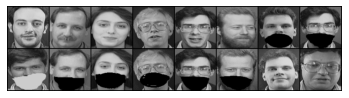

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.6935855150222778

Epoch number 1
 Current loss 5.501447677612305

Epoch number 2
 Current loss 6.215212345123291

Epoch number 3
 Current loss 2.0599586963653564

Epoch number 4
 Current loss 1.5299022197723389

Epoch number 5
 Current loss 1.1585853099822998

Epoch number 6
 Current loss 1.1950711011886597

Epoch number 7
 Current loss 1.9191635847091675

Epoch number 8
 Current loss 0.9483029842376709

Epoch number 9
 Current loss 0.7690998315811157

Epoch number 10
 Current loss 0.9353339672088623

Epoch number 11
 Current loss 0.7797355055809021

Epoch number 12
 Current loss 0.646881103515625

Epoch number 13
 Current loss 0.9079781770706177

Epoch number 14
 Current loss 0.35625767707824707

Epoch number 15
 Current loss 0.32930052280426025

Epoch number 16
 Current loss 0.5033368468284607

Epoch number 17
 Current loss 0.42014187574386597

Epoch number 18
 Current loss 0.24561342597007751

Epoch number 19
 Current loss 0.36864185333251953

Epoch nu

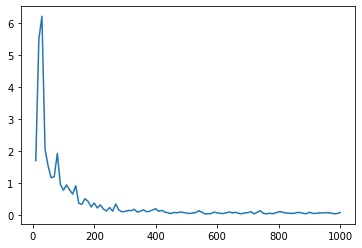

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

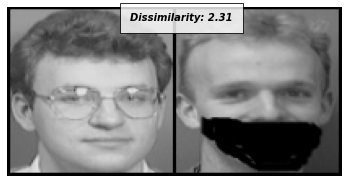

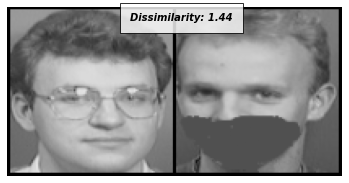

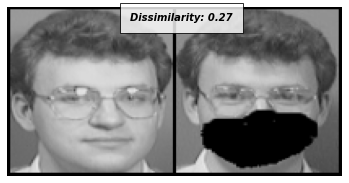

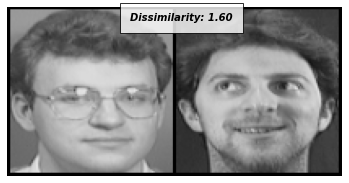

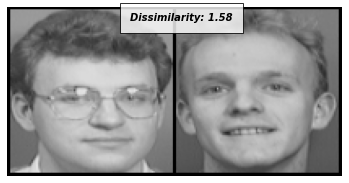

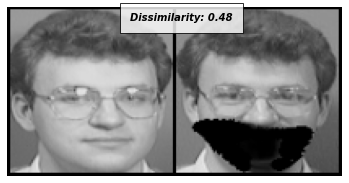

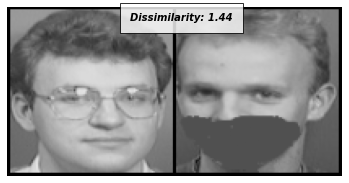

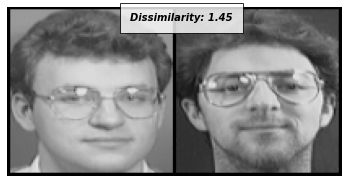

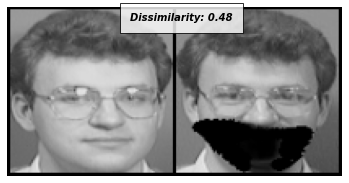

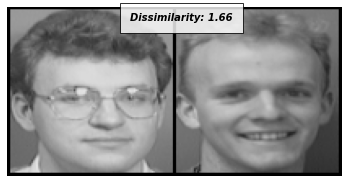

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



### Second **Training**

ContrastiveLoss:
When ytrue is 1, that means the questions are duplicates of each other, so the Euclidean distance (ypred) between their outputs must be minimized. So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).

When ytrue is 0, i.e. the questions are not duplicates, then the Euclidean distance between them must be maximized, at least to the margin. So the loss to be minimized is the difference of the margin and the Euclidean distance - (margin - y_pred). If the Euclidean distance (ypred) is already greater than the margin, then nothing is to be learned, so the loss is made to be zero in that case by saying K.maximum(margin - y_pred, 0)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))




    

accuracy of Siamese Network ad it will be useful for setting a margin. So, why do you learn the Siamese network? Because you want that features extracted from same class was similar and from different class was dissimilar. So to get an accuracy of such process, you need to create a pair of data points(ex. images) with labels same/not same (balanced data). Then just make a verification test, so find distance of each pair and the threshold which give you best overall accuracy of predicting same/not same pairs. This is how you can get accuracy score of Siamese network.



Margin in contrastive loss is more like regulirization constraint it defines hypersphere radius where all similar samples should locate .So from this point of view learning the margin will lead to overtraining “ bias-variance problem”.
From another side of view ,Neural net able to project any data samples into any hypersphere, so Margin value necessity is only to constrain specific net architecture(projection ability) to specific data distribution to filter outliers.

In [ ]:


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.9379851818084717

Epoch number 1
 Current loss 46.944854736328125

Epoch number 2
 Current loss 46.62836456298828

Epoch number 3
 Current loss 48.055442810058594

Epoch number 4
 Current loss 18.52323341369629

Epoch number 5
 Current loss 13.2130126953125

Epoch number 6
 Current loss 6.776883125305176

Epoch number 7
 Current loss 5.027156352996826

Epoch number 8
 Current loss 9.152721405029297

Epoch number 9
 Current loss 6.4634904861450195

Epoch number 10
 Current loss 2.8503732681274414

Epoch number 11
 Current loss 3.5130529403686523

Epoch number 12
 Current loss 4.185122013092041

Epoch number 13
 Current loss 3.068850517272949

Epoch number 14
 Current loss 2.868976593017578

Epoch number 15
 Current loss 2.355984687805176

Epoch number 16
 Current loss 1.629328727722168

Epoch number 17
 Current loss 1.8027324676513672

Epoch number 18
 Current loss 3.1390604972839355

Epoch number 19
 Current loss 2.213954210281372

Epoch number 20
 Curren

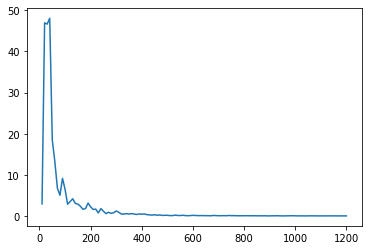

In [ ]:
for epoch in range(0, 120):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [ ]:
##testing

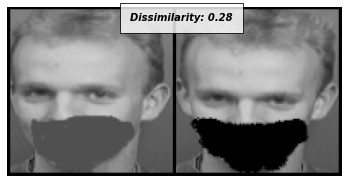

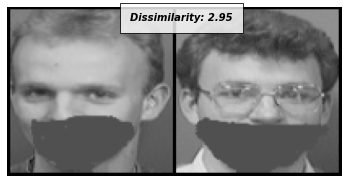

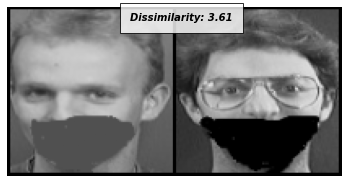

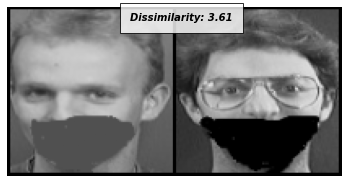

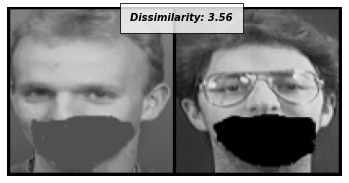

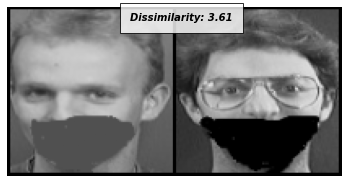

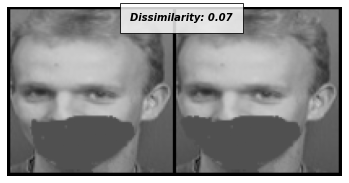

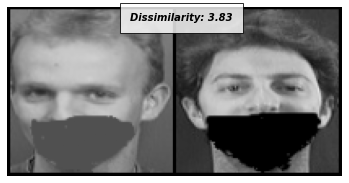

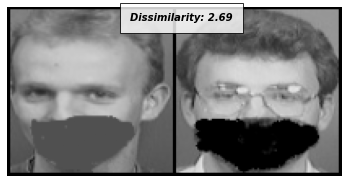

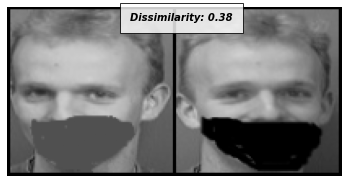

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



# Third Training

ContrastiveLoss:
When ytrue is 1, that means the questions are duplicates of each other, so the Euclidean distance (ypred) between their outputs must be minimized. So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).

When ytrue is 0, i.e. the questions are not duplicates, then the Euclidean distance between them must be maximized, at least to the margin. So the loss to be minimized is the difference of the margin and the Euclidean distance - (margin - y_pred). If the Euclidean distance (ypred) is already greater than the margin, then nothing is to be learned, so the loss is made to be zero in that case by saying K.maximum(margin - y_pred, 0)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))




    

accuracy of Siamese Network ad it will be useful for setting a margin. So, why do you learn the Siamese network? Because you want that features extracted from same class was similar and from different class was dissimilar. So to get an accuracy of such process, you need to create a pair of data points(ex. images) with labels same/not same (balanced data). Then just make a verification test, so find distance of each pair and the threshold which give you best overall accuracy of predicting same/not same pairs. This is how you can get accuracy score of Siamese network.



Margin in contrastive loss is more like regulirization constraint it defines hypersphere radius where all similar samples should locate .So from this point of view learning the margin will lead to overtraining “ bias-variance problem”.
From another side of view ,Neural net able to project any data samples into any hypersphere, so Margin value necessity is only to constrain specific net architecture(projection ability) to specific data distribution to filter outliers.

In [ ]:


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.9379851818084717

Epoch number 1
 Current loss 46.944854736328125

Epoch number 2
 Current loss 46.62836456298828

Epoch number 3
 Current loss 48.055442810058594

Epoch number 4
 Current loss 18.52323341369629

Epoch number 5
 Current loss 13.2130126953125

Epoch number 6
 Current loss 6.776883125305176

Epoch number 7
 Current loss 5.027156352996826

Epoch number 8
 Current loss 9.152721405029297

Epoch number 9
 Current loss 6.4634904861450195

Epoch number 10
 Current loss 2.8503732681274414

Epoch number 11
 Current loss 3.5130529403686523

Epoch number 12
 Current loss 4.185122013092041

Epoch number 13
 Current loss 3.068850517272949

Epoch number 14
 Current loss 2.868976593017578

Epoch number 15
 Current loss 2.355984687805176

Epoch number 16
 Current loss 1.629328727722168

Epoch number 17
 Current loss 1.8027324676513672

Epoch number 18
 Current loss 3.1390604972839355

Epoch number 19
 Current loss 2.213954210281372

Epoch number 20
 Curren

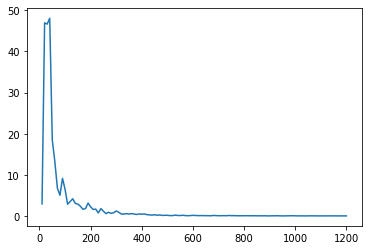

In [ ]:
for epoch in range(0, 120):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

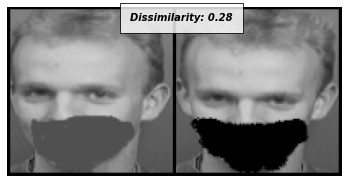

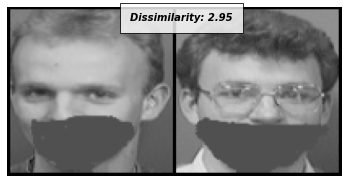

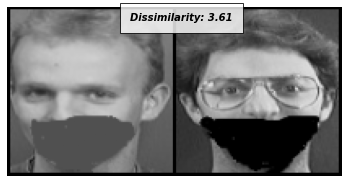

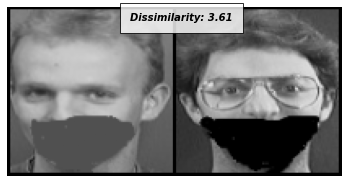

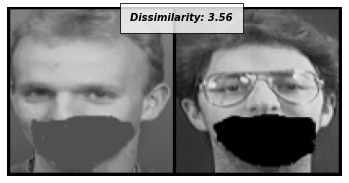

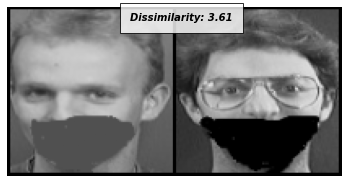

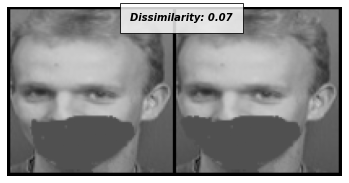

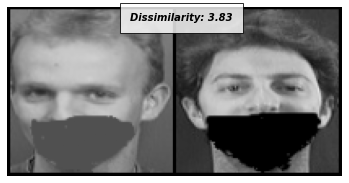

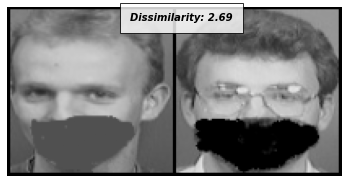

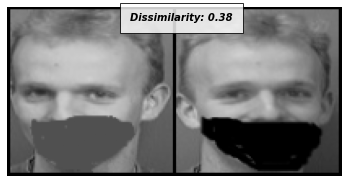

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



## Fourth Training

ContrastiveLoss:
When ytrue is 1, that means the questions are duplicates of each other, so the Euclidean distance (ypred) between their outputs must be minimized. So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).

When ytrue is 0, i.e. the questions are not duplicates, then the Euclidean distance between them must be maximized, at least to the margin. So the loss to be minimized is the difference of the margin and the Euclidean distance - (margin - y_pred). If the Euclidean distance (ypred) is already greater than the margin, then nothing is to be learned, so the loss is made to be zero in that case by saying K.maximum(margin - y_pred, 0)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))




    

accuracy of Siamese Network ad it will be useful for setting a margin. So, why do you learn the Siamese network? Because you want that features extracted from same class was similar and from different class was dissimilar. So to get an accuracy of such process, you need to create a pair of data points(ex. images) with labels same/not same (balanced data). Then just make a verification test, so find distance of each pair and the threshold which give you best overall accuracy of predicting same/not same pairs. This is how you can get accuracy score of Siamese network.



Margin in contrastive loss is more like regulirization constraint it defines hypersphere radius where all similar samples should locate .So from this point of view learning the margin will lead to overtraining “ bias-variance problem”.
From another side of view ,Neural net able to project any data samples into any hypersphere, so Margin value necessity is only to constrain specific net architecture(projection ability) to specific data distribution to filter outliers.

In [ ]:


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.9379851818084717

Epoch number 1
 Current loss 46.944854736328125

Epoch number 2
 Current loss 46.62836456298828

Epoch number 3
 Current loss 48.055442810058594

Epoch number 4
 Current loss 18.52323341369629

Epoch number 5
 Current loss 13.2130126953125

Epoch number 6
 Current loss 6.776883125305176

Epoch number 7
 Current loss 5.027156352996826

Epoch number 8
 Current loss 9.152721405029297

Epoch number 9
 Current loss 6.4634904861450195

Epoch number 10
 Current loss 2.8503732681274414

Epoch number 11
 Current loss 3.5130529403686523

Epoch number 12
 Current loss 4.185122013092041

Epoch number 13
 Current loss 3.068850517272949

Epoch number 14
 Current loss 2.868976593017578

Epoch number 15
 Current loss 2.355984687805176

Epoch number 16
 Current loss 1.629328727722168

Epoch number 17
 Current loss 1.8027324676513672

Epoch number 18
 Current loss 3.1390604972839355

Epoch number 19
 Current loss 2.213954210281372

Epoch number 20
 Curren

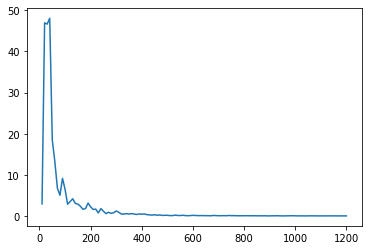

In [ ]:
for epoch in range(0, 120):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

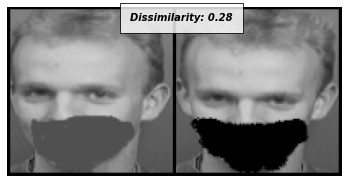

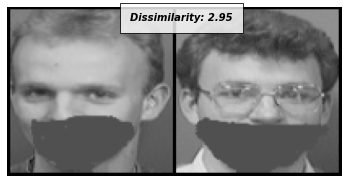

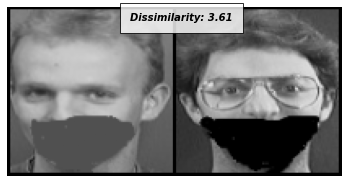

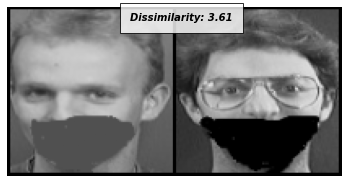

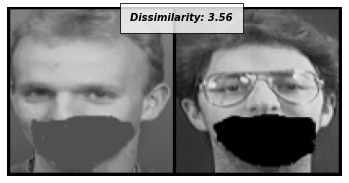

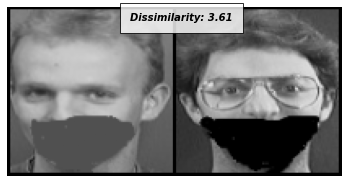

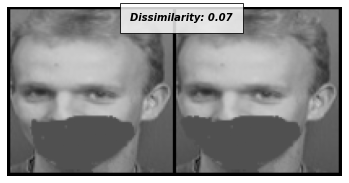

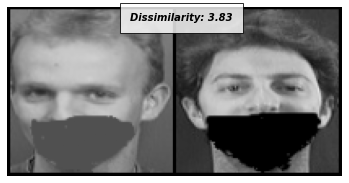

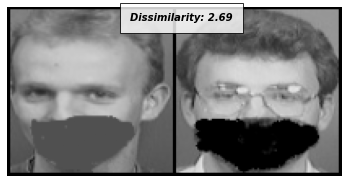

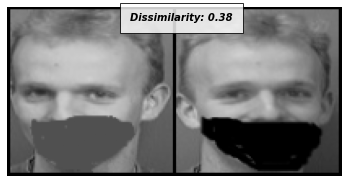

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



### Fifth Training

ContrastiveLoss:
When ytrue is 1, that means the questions are duplicates of each other, so the Euclidean distance (ypred) between their outputs must be minimized. So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).

When ytrue is 0, i.e. the questions are not duplicates, then the Euclidean distance between them must be maximized, at least to the margin. So the loss to be minimized is the difference of the margin and the Euclidean distance - (margin - y_pred). If the Euclidean distance (ypred) is already greater than the margin, then nothing is to be learned, so the loss is made to be zero in that case by saying K.maximum(margin - y_pred, 0)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))




    

accuracy of Siamese Network ad it will be useful for setting a margin. So, why do you learn the Siamese network? Because you want that features extracted from same class was similar and from different class was dissimilar. So to get an accuracy of such process, you need to create a pair of data points(ex. images) with labels same/not same (balanced data). Then just make a verification test, so find distance of each pair and the threshold which give you best overall accuracy of predicting same/not same pairs. This is how you can get accuracy score of Siamese network.



Margin in contrastive loss is more like regulirization constraint it defines hypersphere radius where all similar samples should locate .So from this point of view learning the margin will lead to overtraining “ bias-variance problem”.
From another side of view ,Neural net able to project any data samples into any hypersphere, so Margin value necessity is only to constrain specific net architecture(projection ability) to specific data distribution to filter outliers.

In [ ]:


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.9379851818084717

Epoch number 1
 Current loss 46.944854736328125

Epoch number 2
 Current loss 46.62836456298828

Epoch number 3
 Current loss 48.055442810058594

Epoch number 4
 Current loss 18.52323341369629

Epoch number 5
 Current loss 13.2130126953125

Epoch number 6
 Current loss 6.776883125305176

Epoch number 7
 Current loss 5.027156352996826

Epoch number 8
 Current loss 9.152721405029297

Epoch number 9
 Current loss 6.4634904861450195

Epoch number 10
 Current loss 2.8503732681274414

Epoch number 11
 Current loss 3.5130529403686523

Epoch number 12
 Current loss 4.185122013092041

Epoch number 13
 Current loss 3.068850517272949

Epoch number 14
 Current loss 2.868976593017578

Epoch number 15
 Current loss 2.355984687805176

Epoch number 16
 Current loss 1.629328727722168

Epoch number 17
 Current loss 1.8027324676513672

Epoch number 18
 Current loss 3.1390604972839355

Epoch number 19
 Current loss 2.213954210281372

Epoch number 20
 Curren

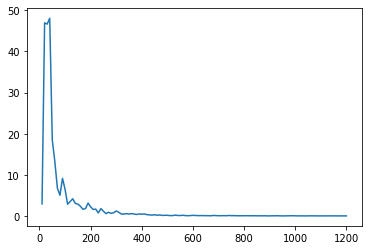

In [ ]:
for epoch in range(0, 120):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

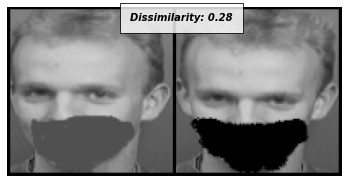

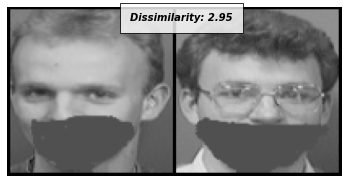

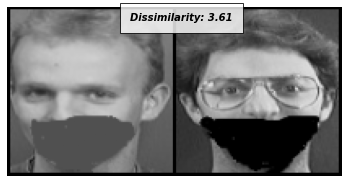

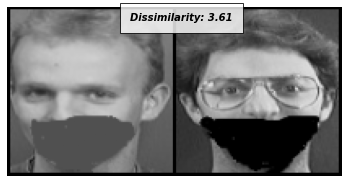

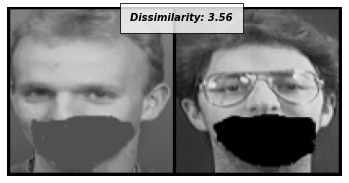

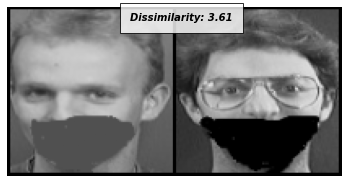

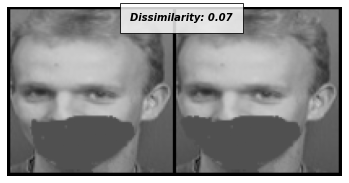

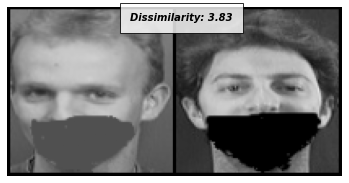

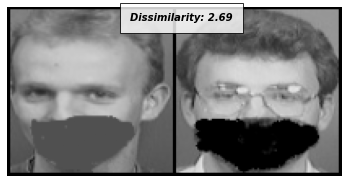

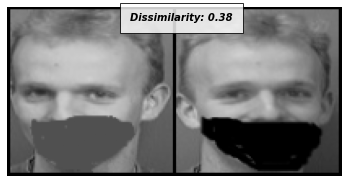

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



## Sixth Training

ContrastiveLoss:
When ytrue is 1, that means the questions are duplicates of each other, so the Euclidean distance (ypred) between their outputs must be minimized. So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).

When ytrue is 0, i.e. the questions are not duplicates, then the Euclidean distance between them must be maximized, at least to the margin. So the loss to be minimized is the difference of the margin and the Euclidean distance - (margin - y_pred). If the Euclidean distance (ypred) is already greater than the margin, then nothing is to be learned, so the loss is made to be zero in that case by saying K.maximum(margin - y_pred, 0)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))




    

accuracy of Siamese Network ad it will be useful for setting a margin. So, why do you learn the Siamese network? Because you want that features extracted from same class was similar and from different class was dissimilar. So to get an accuracy of such process, you need to create a pair of data points(ex. images) with labels same/not same (balanced data). Then just make a verification test, so find distance of each pair and the threshold which give you best overall accuracy of predicting same/not same pairs. This is how you can get accuracy score of Siamese network.



Margin in contrastive loss is more like regulirization constraint it defines hypersphere radius where all similar samples should locate .So from this point of view learning the margin will lead to overtraining “ bias-variance problem”.
From another side of view ,Neural net able to project any data samples into any hypersphere, so Margin value necessity is only to constrain specific net architecture(projection ability) to specific data distribution to filter outliers.

In [ ]:


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.9379851818084717

Epoch number 1
 Current loss 46.944854736328125

Epoch number 2
 Current loss 46.62836456298828

Epoch number 3
 Current loss 48.055442810058594

Epoch number 4
 Current loss 18.52323341369629

Epoch number 5
 Current loss 13.2130126953125

Epoch number 6
 Current loss 6.776883125305176

Epoch number 7
 Current loss 5.027156352996826

Epoch number 8
 Current loss 9.152721405029297

Epoch number 9
 Current loss 6.4634904861450195

Epoch number 10
 Current loss 2.8503732681274414

Epoch number 11
 Current loss 3.5130529403686523

Epoch number 12
 Current loss 4.185122013092041

Epoch number 13
 Current loss 3.068850517272949

Epoch number 14
 Current loss 2.868976593017578

Epoch number 15
 Current loss 2.355984687805176

Epoch number 16
 Current loss 1.629328727722168

Epoch number 17
 Current loss 1.8027324676513672

Epoch number 18
 Current loss 3.1390604972839355

Epoch number 19
 Current loss 2.213954210281372

Epoch number 20
 Curren

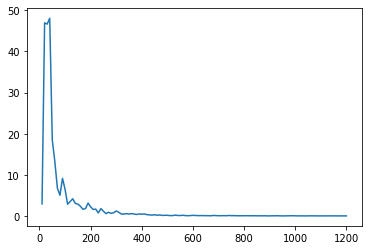

In [ ]:
for epoch in range(0, 120):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

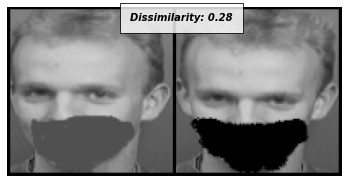

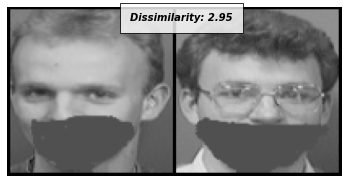

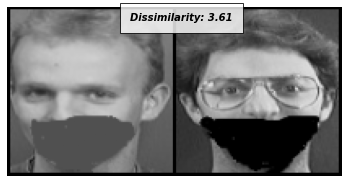

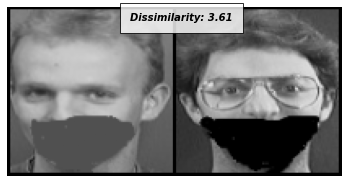

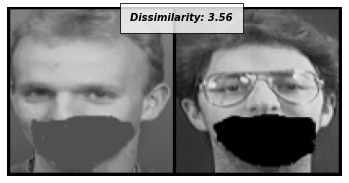

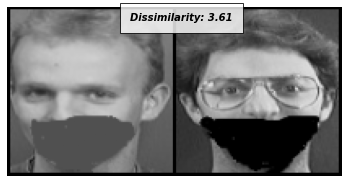

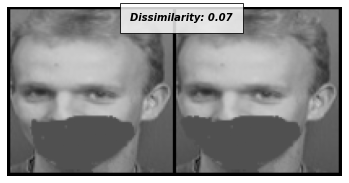

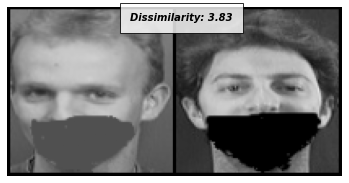

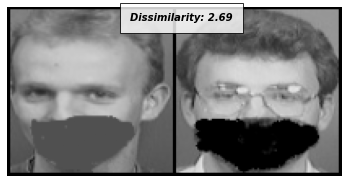

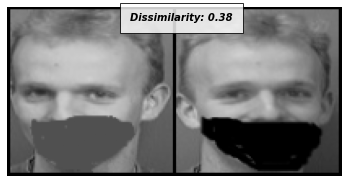

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

